In [1]:
import sys

sys.path.append('../../WCL')

# sys.path.append('/home/saemeechoi/')

# from view import myshow

In [2]:
import os
import math
import time
from math import sqrt
import numpy as np

import torch
import torch.nn as nn
import torch.multiprocessing as mp

import torchvision.transforms as transforms

from data import get_dataset
from data.augmentation import *

from util.meter import *
from util.torch_dist_sum import *
from util.accuracy import accuracy
from util.LARS import LARS
from util.parsing import set_seed
from util import parsing
from tqdm import tqdm

from network.wcl import WCL
from torch.distributed import init_process_group, destroy_process_group

In [3]:
from easydict import EasyDict as edict
args = edict({
    'batch_size':256,
    'epochs':100,
    'warmup_epochs':10,
    'gpu_ids':3,
    
    'dataset':'task1',
    'data_path': './data/dataset',
    
    'noise_type':'pairflip',
    'closeset_ratio':0.4,
    'openset_ratio':0.2,
    
    'ngpus':torch.cuda.device_count(),
    'num_workers':4
    
})

In [4]:
train_dataset = get_dataset(args)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=args.batch_size, shuffle=False,
    num_workers=args.num_workers, pin_memory=True, drop_last=True)

100%|███████████████████████████████████████████████████████| 53897/53897 [00:43<00:00, 1243.07it/s]


# Load Model

In [5]:
model = WCL(dim_input=len(train_dataset[0][0]))

checkpoint_path = '../checkpoints/wcl-100.pth'
checkpoint =  torch.load(checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])
model.eval()

WCL(
  (net): ProjectionHead(
    (linear1): Linear(in_features=27694, out_features=4096, bias=True)
    (bn1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (linear2): Linear(in_features=4096, out_features=4096, bias=True)
    (bn2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (linear3): Linear(in_features=4096, out_features=4096, bias=True)
  )
  (head): ProjectionHead(
    (linear1): Linear(in_features=4096, out_features=4096, bias=True)
    (bn1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (linear2): Linear(in_features=4096, out_features=4096, bias=True)
    (bn2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (linear3): Linear(in_features=4096, out_features=256, bias=True)
  )
)

# Inference

In [6]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
import torch.nn.functional as F

def build_connected_component(dist):
    b = dist.size(0)
    dist = dist - torch.eye(b, b) * 2
    
    x = torch.arange(b).unsqueeze(1).repeat(1,1).flatten()
    y = torch.topk(dist, 1, dim=1, sorted=False)[1].flatten()
    rx = torch.cat([x, y]).numpy()
    ry = torch.cat([y, x]).numpy()
    
    v = np.ones(rx.shape[0])
    graph = csr_matrix((v, (rx, ry)), shape=(b,b))
    _, labels = connected_components(csgraph=graph, directed=False, return_labels=True)
    labels = torch.tensor(labels)
    mask = torch.eq(labels.unsqueeze(1), labels.unsqueeze(1).T)
    return mask

data_dict = {}
for i, (data, user_id) in enumerate(train_loader):
        x = torch.unsqueeze(data,1)
        
        b = x.size(0)
        x = x.reshape(b, -1).float()
        
        backbone_feat = model.net(x)
        feat = F.normalize(model.head(backbone_feat))
        
        mask = build_connected_component(feat @ feat.T).float()
        label_list = np.unique(np.array(mask), axis=0)
        
        id2label = {}
        for i, m in enumerate(label_list):
            for id in np.where(m)[0]:
                id2label[id] = i
        
        for (id, rep) in zip(user_id, backbone_feat):
            data_dict[int(id)] = {
                'rep': rep.detach(),
                'label': id2label[int(id)]
            }
        break

In [17]:
from collections import Counter

countdict = Counter(list(id2label.values()))
{k: v for k, v in sorted(countdict.items(), key=lambda item: item[1], asc)}

{0: 2,
 2: 2,
 3: 2,
 4: 2,
 5: 2,
 7: 2,
 8: 2,
 11: 2,
 14: 2,
 16: 2,
 18: 2,
 22: 2,
 28: 2,
 32: 2,
 33: 2,
 37: 2,
 39: 2,
 40: 2,
 43: 2,
 44: 2,
 45: 2,
 46: 2,
 48: 2,
 50: 2,
 52: 2,
 53: 2,
 56: 2,
 57: 2,
 58: 2,
 62: 2,
 68: 2,
 72: 2,
 78: 2,
 79: 2,
 1: 3,
 6: 3,
 9: 3,
 10: 3,
 12: 3,
 13: 3,
 19: 3,
 20: 3,
 21: 3,
 24: 3,
 25: 3,
 26: 3,
 27: 3,
 29: 3,
 31: 3,
 38: 3,
 42: 3,
 47: 3,
 51: 3,
 69: 3,
 15: 4,
 17: 4,
 41: 4,
 49: 4,
 54: 4,
 59: 4,
 60: 4,
 61: 4,
 75: 4,
 76: 4,
 23: 5,
 34: 5,
 35: 5,
 36: 5,
 55: 5,
 63: 5,
 64: 5,
 66: 5,
 70: 5,
 73: 5,
 74: 5,
 67: 6,
 71: 6,
 77: 6,
 65: 7,
 30: 8}

In [26]:
representation_list = []
label_list = []
sampled_label = [23,34,35,36,55,63,64,66,70,73,74,67,71,77,65,30]
for id in data_dict.keys():
    label = data_dict[id]['label']
    if label in sampled_label:
        rep = data_dict[id]['rep']

        representation_list.append(rep)
        label_list.append(label)
    
representation_tensor = torch.stack(representation_list)

### t-SNE

In [27]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming your data is stored in a numpy array called 'data'
tsne = TSNE(n_components=2, perplexity=30.0)
embedded_data = tsne.fit_transform(representation_tensor)

In [31]:
label2norm_label = {label:i for i, label in enumerate(sampled_label)}
label_list = [label2norm_label[label] for label in label_list]

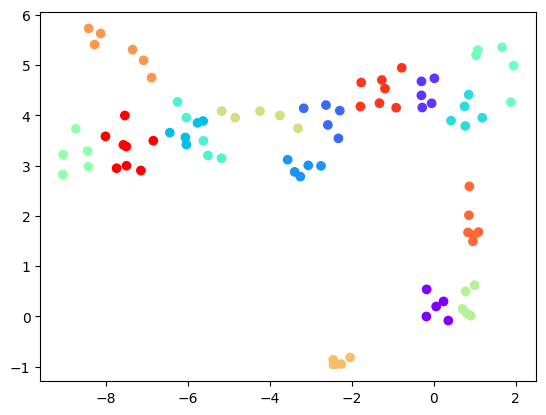

In [35]:
# Plot the embedded data
# 10개 sample
plt.scatter(embedded_data[:, 0], embedded_data[:, 1], c=label_list,cmap='rainbow')
plt.show()

### UMAP

In [36]:
import umap.umap_ as umap
import numpy as np
import matplotlib.pyplot as plt

umap_obj = umap.UMAP(n_components=2)

# Fit and transform the data using UMAP
embedding = umap_obj.fit_transform(representation_tensor)

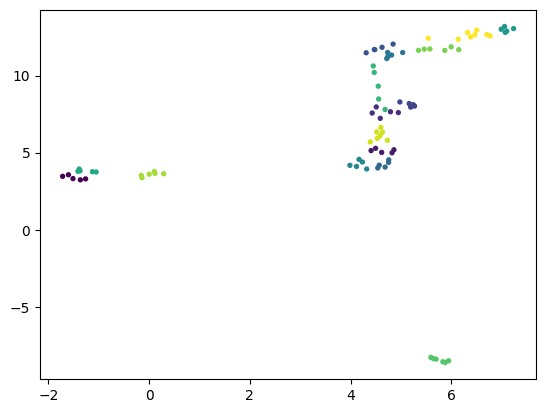

In [37]:
# Plot the results
plt.scatter(embedding[:, 0], embedding[:, 1], c=label_list, cmap='viridis',s=8) # , c=clean_target_list
plt.show()

In [38]:
# Plot the embedded data
from mpl_toolkits.mplot3d import Axes3D

# Assuming your data is stored in a numpy array called 'data'
umap_obj = umap.UMAP(n_components=3)

# Fit and transform the data using UMAP
embedded_data = umap_obj.fit_transform(representation_tensor)

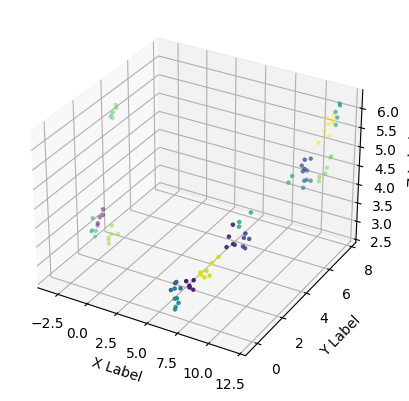

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(embedded_data[:, 0], embedded_data[:, 1], embedded_data[:, 2], c=label_list, cmap='viridis', s=5)

# Set the plot labels
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Show the plot
plt.show()

In [40]:
import plotly.express as px
import pandas as pd

# Create a sample data frame with three variables
df = pd.DataFrame(embedded_data, columns=['x','y','z'])
df['color'] = label_list

# Create the 3D scatter plot using Plotly
fig = px.scatter_3d(df, x='x', y='y', z='z', color='color')
fig.update_traces(marker=dict(size=2))
# Show the plot
fig.show()
